# EDA Simulation Statistics

Steve Donahue, www.github.com/sdonahue0132

This notebook

1) Loads csv files generated by the EDA + Simulation notebook

2) Analyzes the performance of the best All Weather Portfolios

3) Analyzes portfolios with alternate fund category weights

4) Proposes specific funds with which to build an optimal All Weather Portfolio


In [1]:
# Import essential libraries #

import pandas as pd
import numpy as np
from numpy import percentile
import math
import datetime
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functools import reduce
import warnings
from random import randint
import seaborn as sns
%matplotlib inline

warnings.filterwarnings(action='once')

In [2]:
# Read this csv to load the All Weather Portfolios for the next several cell analysis
data_set = pd.read_csv('csv_files/7000_all_weather_portfolios.csv')
data_set = data_set[['Portfolio', 'Weeks_until_Rebalance', 'Biweekly_Contribution', 'Worst_Year', 
                   'Best_Year', 'Estimated_Annual_Return', 'Typical_Returns']]
data_set = data_set.sort_values(['Estimated_Annual_Return', 'Biweekly_Contribution', 'Worst_Year'], 
                                ascending = [False, True, True])


Percentage of portfolios above 9% Annual Return: 100.0


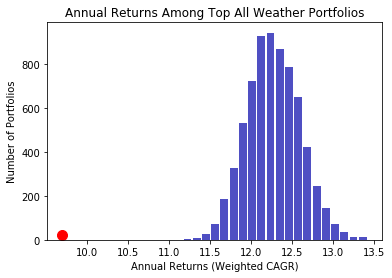

In [3]:
# Early exploration of whether 9% returns are common.  Needs a true hypothesis test: Is the mean of the data set 9?

count_above_9 = 0
for i in data_set['Estimated_Annual_Return']:
    if i > 9.7:
        count_above_9 = count_above_9 + 1

above_9_ratio = count_above_9/data_set.shape[0]*100

plt.hist(data_set['Estimated_Annual_Return'], bins = 20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.plot([9.7],[20], 'ro', markersize = 10)
plt.xlabel('Annual Returns (Weighted CAGR)')
plt.ylabel('Number of Portfolios')
plt.title('Annual Returns Among Top All Weather Portfolios')
plt.show

print('Percentage of portfolios above 9% Annual Return: ' + str(above_9_ratio))

<function matplotlib.pyplot.show(*args, **kw)>

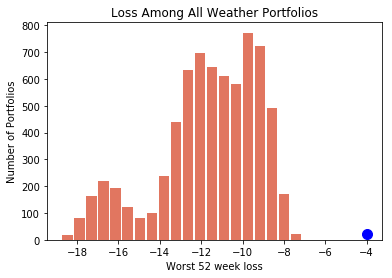

In [4]:
plt.hist(data_set['Worst_Year'], bins = 20, color='#D53C1C',
                            alpha=0.7, rwidth=0.85)

plt.plot([-4],[20], 'bo', markersize = 10)
plt.xlabel('Worst 52 week loss')
plt.ylabel('Number of Portfolios')
plt.title('Loss Among All Weather Portfolios')
plt.show



Text(0.5, 1.0, 'Density of All Weather Portfolios')

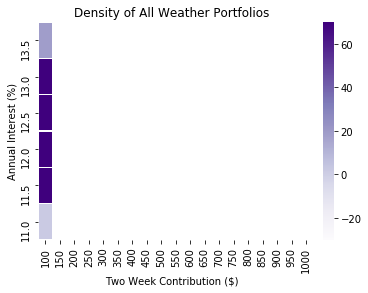

In [5]:
def set_grapher(df):

    graphing_set = df

    graphing_set['rounded_estimates'] = round(df['Estimated_Annual_Return']* 2)/2

    graphing_set.columns = ['Portfolio', 'Weeks', 'Two Week Contribution ($)', 'Worst Year', 
                    'Best Year', 'Estimated Return', 'Typical', 'Annual Interest (%)']

    grouped = graphing_set.groupby(['Annual Interest (%)', 'Two Week Contribution ($)'])['Estimated Return'].count()

    new_df = grouped.to_frame(name = 'count')
    new_df = new_df.unstack()
    new_df.columns = new_df.columns.droplevel()

    labels = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
    ax = sns.heatmap(new_df, annot=False, cmap = "Purples", vmin =-30, vmax = 70, linewidths = .1, xticklabels = labels)
    ax.invert_yaxis()

    return(ax)

ax = set_grapher(data_set)
ax.set_title('Density of All Weather Portfolios')


In [12]:
# Is there a statistically significant difference in the distribution of returns when you invest $100 per pay period
# versus $1000 per pay period?  Let's do a boot strap hypothesis test with the two distributions.

data_set = pd.read_csv('csv_files/7000_all_weather_portfolios.csv')
data_set = data_set[['Portfolio', 'Weeks_until_Rebalance', 'Biweekly_Contribution', 'Worst_Year', 
                   'Best_Year', 'Estimated_Annual_Return', 'Typical_Returns']]
data_set = data_set.sort_values(['Estimated_Annual_Return', 'Biweekly_Contribution', 'Worst_Year'], 
                                ascending = [False, True, True])

invest_100 = data_set.loc[data_set['Biweekly_Contribution'] == 500]
invest_1000 = data_set.loc[data_set['Biweekly_Contribution'] == 500]

returns_100 = invest_100.loc[:, 'Estimated_Annual_Return'].values
returns_1000 = invest_1000.loc[:, 'Estimated_Annual_Return'].values

# These arrays of returns form the two distributions that we'll be testing.

# First, let's define the boostrap rep creation functions
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

# Compute the difference in mean returns: diff_means
diff_means = np.mean(returns_100) - np.mean(returns_1000)

# Compute mean of pooled data: mean_count
mean_count = np.mean(np.concatenate((returns_100, returns_1000)))

# Generate shifted data sets
shifted_100 = returns_100 - np.mean(returns_100) + mean_count
shifted_1000 = returns_1000 - np.mean(returns_1000) + mean_count

# Generate bootstrap replicates
bs_reps_100 = draw_bs_reps(shifted_100,
                       np.mean, size=10000)
bs_reps_1000 = draw_bs_reps(shifted_1000,
                       np.mean, size=10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_reps_100 -  bs_reps_1000

# Compute and print p-value: p
p = np.sum(bs_replicates >= np.mean(returns_100) - np.mean(returns_1000)) \
            / len(bs_replicates)
print('p-value =', p)

p-value = 0.5009


Note that the likelihood of getting such similar distributions due to chance is about 48%.  There is no reason to
believe that these two distributions are different!  Thus, the kinds of CAGR you can capture by investing
with an All Weather Portfolio are accessible regardless of how much you are investing (between 100 and $1000) at least.


In [13]:
# This Cell explores the likelihood of an individual fund's presence in an AW portfolio and the likelihood
# of that portfolio having over 9% return vs the likelihood of it occurring in a portfolio with performance under 9%

over_9_df = data_set[data_set['Estimated_Annual_Return'] > 13]
under_9_df = data_set[data_set['Estimated_Annual_Return'] <= 13]
master_list = pd.DataFrame()

for j in range(over_9_df.shape[0]):
    funds = over_9_df.reset_index()['Portfolio']
    listed = funds[j].replace("'", "").replace(' ','').split(',')
    master_list = master_list.append(listed)

master_list.columns = ['Success_Index']
summary_over_9 = master_list['Success_Index'].value_counts()

master_list = pd.DataFrame()
for j in range(under_9_df.shape[0]):
    funds = under_9_df.reset_index()['Portfolio']
    listed = funds[j].replace("'", "").replace(' ','').split(',')
    master_list = master_list.append(listed)
    
master_list.columns = ['Failure_Index']
summary_under_9 = master_list['Failure_Index'].value_counts()

df_over_9 = summary_over_9.reset_index()
df_over_9['Success_Index'] = df_over_9['Success_Index']/over_9_df.shape[0]

df_under_9 = summary_under_9.reset_index()
df_under_9['Failure_Index'] = df_under_9['Failure_Index']/under_9_df.shape[0]

comparison_df = df_over_9.merge(df_under_9, how = 'outer', left_on = 'index', right_on = 'index')
comparison_df

recommended_funds = comparison_df[comparison_df['Success_Index'] > comparison_df['Failure_Index']]
recommended_funds


,index,Success_Index,Failure_Index
0,VIGRX,0.74,0.197971
1,WHOSX,0.63,0.330435
2,DBC,0.55,0.231159
3,IEF,0.36,0.122029
4,INIVX,0.32,0.206667
5,HYG,0.29,0.123913
6,SGGDX,0.25,0.196377
8,BIV,0.21,0.122029


In [14]:
recommendation = "'VIGRX', 'IEF', 'WHOSX', 'SGGDX', 'DBC'"

data_set[data_set['Portfolio'] == recommendation]


,Portfolio,Weeks_until_Rebalance,Biweekly_Contribution,Worst_Year,Best_Year,Estimated_Annual_Return,Typical_Returns
18,"'VIGRX', 'IEF', 'WHOSX', 'SGGDX', 'DBC'",47.0,500.0,-7.68,21.34,13.27,-3.84 to 15.26
74,"'VIGRX', 'IEF', 'WHOSX', 'SGGDX', 'DBC'",4.0,500.0,-8.65,19.66,13.06,-5.23 to 15.24
116,"'VIGRX', 'IEF', 'WHOSX', 'SGGDX', 'DBC'",19.0,500.0,-8.12,19.31,12.98,-4.73 to 14.64


In [44]:
# Here, additional variations of the same analysis above are given for portfolios of different proportions.  
# First, we have a stock-heavy  60%, 10%, 10%, 10%, 10% scheme.

In [45]:
data_set = pd.read_csv('csv_files/5000_60_10_10_10_10_portfolios.csv')
data_set = data_set[['Portfolio', 'Weeks_until_Rebalance', 'Biweekly_Contribution', 'Worst_Year', 
                   'Best_Year', 'Estimated_Annual_Return', 'Typical_Returns']]
data_set = data_set.sort_values(['Estimated_Annual_Return', 'Biweekly_Contribution', 'Worst_Year'], 
                                ascending = [False, True, True])

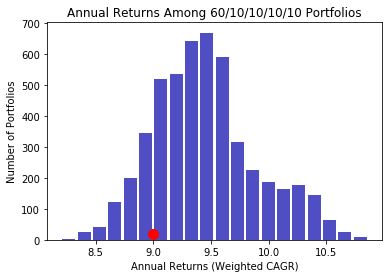

In [46]:
# This Cell develops return visualizations for 5000 portfolios with the distribution scheme .60, .10, .10, .10, .10
count_above_9 = 0
for i in data_set['Estimated_Annual_Return']:
    if i > 9:
        count_above_9 = count_above_9 + 1
count_above_9/data_set.shape[0]*100

plt.hist(data_set['Estimated_Annual_Return'], bins = 20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.plot([9],[20], 'ro', markersize = 10)
plt.xlabel('Annual Returns (Weighted CAGR)')
plt.ylabel('Number of Portfolios')
plt.title('Annual Returns Among 60/10/10/10/10 Portfolios')
plt.show

most_worst = str(min(data_set['Worst_Year']))
least_worst = str(max(data_set['Worst_Year']))


<function matplotlib.pyplot.show(*args, **kw)>

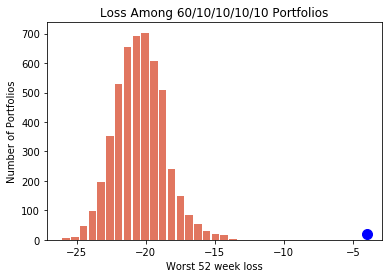

In [47]:
# This cell develops loss visualizations for a portfolio with distribution scheme .60, .10, .10, .10, .10

plt.hist(data_set['Worst_Year'], bins = 20, color='#D53C1C',
                            alpha=0.7, rwidth=0.85)

plt.plot([-4],[20], 'bo', markersize = 10)
plt.xlabel('Worst 52 week loss')
plt.ylabel('Number of Portfolios')
plt.title('Loss Among 60/10/10/10/10 Portfolios')
plt.show

Text(0.5,1,'Density of 60/10/10/10/10 Portfolios')

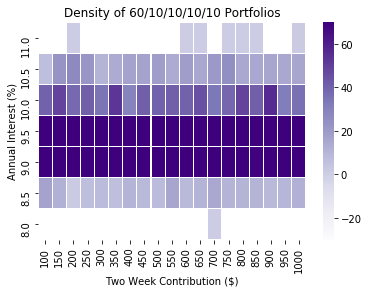

In [48]:
# Heat map for number of portfolios with distribution scheme .60, .10, .10, .10, .10

ax = set_grapher(data_set)
ax.set_title('Density of 60/10/10/10/10 Portfolios')

In [ ]:
# Secondly, we have a less stock heavy scheme of 15% stock, 35% intermediate bonds, 
# 25% long term bonds, 12.5% gold, and 12.5% commodities.
# Interestingly enough, it is often suggested that retirees hold more of their portfolios in bonds
# However, the losses during a downturn are still quite ugly despite how common that advice is given.

In [49]:
data_set = pd.read_csv('csv_files/5000_15_35_25_12.5_12.5_portfolios.csv')
data_set = data_set[['Portfolio', 'Weeks_until_Rebalance', 'Biweekly_Contribution', 'Worst_Year', 
                   'Best_Year', 'Estimated_Annual_Return', 'Typical_Returns']]
data_set = data_set.sort_values(['Estimated_Annual_Return', 'Biweekly_Contribution', 'Worst_Year'], 
                                ascending = [False, True, True])

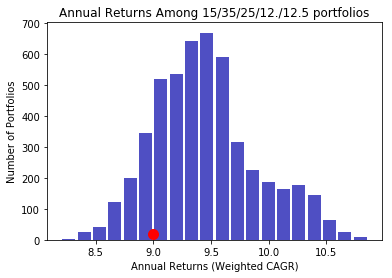

In [50]:
count_above_9 = 0
for i in data_set['Estimated_Annual_Return']:
    if i > 9:
        count_above_9 = count_above_9 + 1
count_above_9/data_set.shape[0]*100

plt.hist(data_set['Estimated_Annual_Return'], bins = 20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.plot([9],[20], 'ro', markersize = 10)
plt.xlabel('Annual Returns (Weighted CAGR)')
plt.ylabel('Number of Portfolios')
plt.title('Annual Returns Among 15/35/25/12./12.5 portfolios')
plt.show

most_worst = str(min(data_set['Worst_Year']))
least_worst = str(max(data_set['Worst_Year']))

#print('The Returns across the "15/35/25/12.5/12.5" portfolios in their worst 52 week period range from ' + most_worst + ' to ' + least_worst + '.' )

<function matplotlib.pyplot.show(*args, **kw)>

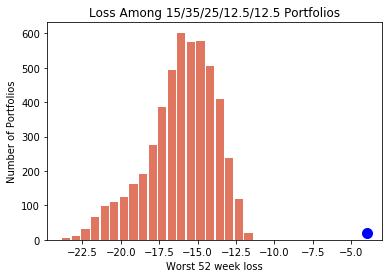

In [51]:
plt.hist(data_set['Worst_Year'], bins = 20, color='#D53C1C',
                            alpha=0.7, rwidth=0.85)

plt.plot([-4],[20], 'bo', markersize = 10)
plt.xlabel('Worst 52 week loss')
plt.ylabel('Number of Portfolios')
plt.title('Loss Among 15/35/25/12.5/12.5 Portfolios')
plt.show

Text(0.5,1,'Density of 15/35/25/12.5/12.5 Portfolios')

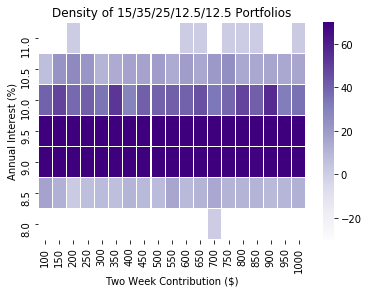

In [52]:
ax = set_grapher(data_set)
ax.set_title('Density of 15/35/25/12.5/12.5 Portfolios')

In [53]:
over_9_df = data_set[data_set['Estimated Return'] > 9]
under_9_df = data_set[data_set['Estimated Return'] <= 9]
master_list = pd.DataFrame()

for j in range(over_9_df.shape[0]):
    funds = over_9_df.reset_index()['Portfolio']
    listed = funds[j].replace("'", "").replace(' ','').split(',')
    master_list = master_list.append(listed)

master_list.columns = ['Success_Index']
summary_over_9 = master_list['Success_Index'].value_counts()

master_list = pd.DataFrame()
for j in range(under_9_df.shape[0]):
    funds = under_9_df.reset_index()['Portfolio']
    listed = funds[j].replace("'", "").replace(' ','').split(',')
    master_list = master_list.append(listed)
    
master_list.columns = ['Failure_Index']
summary_under_9 = master_list['Failure_Index'].value_counts()


df_over_9 = summary_over_9.reset_index()
df_over_9['Success_Index'] = df_over_9['Success_Index']/over_9_df.shape[0]

df_under_9 = summary_under_9.reset_index()
df_under_9['Failure_Index'] = df_under_9['Failure_Index']/under_9_df.shape[0]

comparison_df = df_over_9.merge(df_under_9, how = 'outer', left_on = 'index', right_on = 'index')
comparison_df

recommended_funds = comparison_df[comparison_df['Success_Index'] > comparison_df['Failure_Index']]


,index,Success_Index,Failure_Index
0,WHOSX,0.344053,0.243839
3,DBC,0.275479,0.133593
8,USERX,0.218018,0.147860
9,INIVX,0.217309,0.107652
10,SGGDX,0.212343,0.092088
11,OPGSX,0.206432,0.110246
17,IEF,0.138567,0.077821
18,IPE,0.132183,0.121920
19,IEI,0.128163,0.086900
20,BIV,0.127690,0.111543


In [ ]:
# Since the returns and losses are not superior to the All Weather portfolio (30/40/15/7.5/7.5), 
# Additional recommendations will not be made using the above data.